In [1]:
"""
AAI511_Group11_Model_Training_Optimized.ipynb

This script performs the following steps:
1.  Loads preprocessed training, validation, and test data.
2.  Defines flexible CNN and LSTM model architectures.
3.  Sets up hyperparameter search spaces for both models.
4.  Implements a robust training and evaluation pipeline.
5.  Conducts a grid search to find the optimal hyperparameters for both models based on validation accuracy.
6.  Trains the final models using the best-found hyperparameters.
7.  Evaluates the final models on the test set and provides a clear performance comparison.
8.  Visualizes the training loss of the final models.
"""
# Group Members: Abhay, Aditya, Sukani
# Optimized and Refactored Version

'\nAAI511_Group11_Model_Training_Optimized.ipynb\n\nThis script performs the following steps:\n1.  Loads preprocessed training, validation, and test data.\n2.  Defines flexible CNN and LSTM model architectures.\n3.  Sets up hyperparameter search spaces for both models.\n4.  Implements a robust training and evaluation pipeline.\n5.  Conducts a grid search to find the optimal hyperparameters for both models based on validation accuracy.\n6.  Trains the final models using the best-found hyperparameters.\n7.  Evaluates the final models on the test set and provides a clear performance comparison.\n8.  Visualizes the training loss of the final models.\n'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import itertools
import warnings

# Suppress the UserWarning from sklearn.metrics
warnings.filterwarnings("ignore", category=UserWarning)

# --- 1. Device Configuration and Data Loading ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Mount Google Drive to access data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def load_data(tensor_dir):
    """Loads preprocessed data tensors from the specified directory."""
    print("\nLoading preprocessed data...")
    train_data = torch.load(f'{tensor_dir}/train_data.pt')
    test_data = torch.load(f'{tensor_dir}/test_data.pt')
    val_data = torch.load(f'{tensor_dir}/val_data.pt')

    X_train = train_data['features'].float()
    y_train = train_data['labels'].long()
    train_lengths = train_data['lengths']

    X_test = test_data['features'].float()
    y_test = test_data['labels'].long()
    test_lengths = test_data['lengths']

    X_val = val_data['features'].float()
    y_val = val_data['labels'].long()
    val_lengths = val_data['lengths']

    print("Data loading complete.")
    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")
    print(f"Test data shape: {X_test.shape}")

    return (X_train, y_train, train_lengths), \
           (X_test, y_test, test_lengths), \
           (X_val, y_val, val_lengths)

In [5]:
class SequenceDataset(Dataset):
    """Custom Dataset for handling features, labels, and sequence lengths."""
    def __init__(self, features, labels, lengths):
        self.features = features
        self.labels = labels
        self.lengths = lengths

    def __getitem__(self, index):
        return self.features[index], self.labels[index], self.lengths[index]

    def __len__(self):
        return len(self.labels)

In [6]:
# --- 2. Model Architectures ---

class CNN(nn.Module):
    """Convolutional Neural Network for sequence classification."""
    def __init__(self, input_features, num_classes, sequence_length, num_filters=32, kernel_size=3, dropout_prob=0.0):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_features, out_channels=num_filters, kernel_size=kernel_size, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters * 2, kernel_size=kernel_size, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        # Dynamically calculate the flattened size
        with torch.no_grad():
            dummy_input = torch.randn(1, input_features, sequence_length)
            conv_output = self._get_conv_output(dummy_input)
            flattened_size = conv_output.view(1, -1).size(1)

        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(flattened_size, num_classes)

    def _get_conv_output(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        return x

    def forward(self, x):
        # Permute input from (batch, seq_len, features) to (batch, features, seq_len)
        x = x.permute(0, 2, 1)
        x = self._get_conv_output(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = self.fc(x)
        return x

class LSTM(nn.Module):
    """Long Short-Term Memory network for sequence classification."""
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_prob=0.0):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, lengths):
        # Pack padded sequence
        packed_input = torch.nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)

        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        packed_output, (hn, _) = self.lstm(packed_input, (h0, c0))

        # Use the hidden state from the last layer
        last_hidden_state = self.dropout(hn[-1, :, :])
        out = self.fc(last_hidden_state)
        return out

In [7]:
# --- 3. Training and Evaluation Pipeline ---

def evaluate_model(model, data_loader, criterion, device):
    """Evaluates the model on a given dataset."""
    model.eval()
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for features, labels, lengths in data_loader:
            features, labels, lengths = features.to(device), labels.to(device), lengths.to(device)

            if isinstance(model, LSTM):
                outputs = model(features, lengths)
            else:
                outputs = model(features)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)

    return avg_loss, accuracy, precision, recall

def train_model(model, train_loader, optimizer, criterion, device, num_epochs):
    """Trains the model for a specified number of epochs."""
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for features, labels, lengths in train_loader:
            features, labels, lengths = features.to(device), labels.to(device), lengths.to(device)

            # Forward pass
            if isinstance(model, LSTM):
                outputs = model(features, lengths)
            else:
                outputs = model(features)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    return train_losses

In [8]:
# --- 4. Hyperparameter Tuning ---

def hyperparameter_grid_search(model_type, param_grid, data, num_tuning_epochs):
    """Performs a grid search to find the best hyperparameters."""
    (X_train, y_train, train_lengths), (X_val, y_val, val_lengths) = data
    train_loader = DataLoader(SequenceDataset(X_train, y_train, train_lengths), batch_size=64, shuffle=True)
    val_loader = DataLoader(SequenceDataset(X_val, y_val, val_lengths), batch_size=64)

    best_accuracy = 0
    best_params = None
    results = []

    # Get grid combinations
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    print(f"\n--- Starting Hyperparameter Tuning for {model_type} ---")
    print(f"Testing {len(param_combinations)} combinations over {num_tuning_epochs} epochs each.")

    for i, params in enumerate(param_combinations):
        print(f"\n[{i+1}/{len(param_combinations)}] Testing params: {params}")

        # Extract learning rate and model-specific parameters
        learning_rate = params.get('learning_rate', 0.001)
        model_params = {k: v for k, v in params.items() if k != 'learning_rate'}

        # Instantiate model with current params
        if model_type == 'CNN':
            model = CNN(
                input_features=X_train.shape[2],
                num_classes=len(torch.unique(y_train)),
                sequence_length=X_train.shape[1],
                **model_params  # Pass only model-specific params
            ).to(device)
        else: # LSTM
            model = LSTM(
                input_size=X_train.shape[2],
                num_classes=len(torch.unique(y_train)),
                **model_params # Pass only model-specific params
            ).to(device)

        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        # Train for a few epochs
        train_model(model, train_loader, optimizer, criterion, device, num_tuning_epochs)

        # Evaluate on validation set
        _, val_accuracy, _, _ = evaluate_model(model, val_loader, criterion, device)
        print(f"Validation Accuracy: {val_accuracy:.4f}")

        results.append({'params': params, 'val_accuracy': val_accuracy})

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params

    print(f"\n--- Finished {model_type} Hyperparameter Tuning ---")
    print(f"Best Validation Accuracy: {best_accuracy:.4f}")
    print(f"Best Parameters: {best_params}")

    return best_params


Loading preprocessed data...
Data loading complete.
Training data shape: torch.Size([1066, 500, 4])
Validation data shape: torch.Size([153, 500, 4])
Test data shape: torch.Size([305, 500, 4])

--- Starting Hyperparameter Tuning for CNN ---
Testing 16 combinations over 3 epochs each.

[1/16] Testing params: {'learning_rate': 0.001, 'num_filters': 32, 'kernel_size': 3, 'dropout_prob': 0.2}
Epoch [1/3], Loss: 1.0283
Epoch [2/3], Loss: 0.8794
Epoch [3/3], Loss: 0.8522
Validation Accuracy: 0.6601

[2/16] Testing params: {'learning_rate': 0.001, 'num_filters': 32, 'kernel_size': 3, 'dropout_prob': 0.4}
Epoch [1/3], Loss: 1.0263
Epoch [2/3], Loss: 0.9223
Epoch [3/3], Loss: 0.8752
Validation Accuracy: 0.6601

[3/16] Testing params: {'learning_rate': 0.001, 'num_filters': 32, 'kernel_size': 5, 'dropout_prob': 0.2}
Epoch [1/3], Loss: 1.0736
Epoch [2/3], Loss: 0.8928
Epoch [3/3], Loss: 0.8482
Validation Accuracy: 0.6601

[4/16] Testing params: {'learning_rate': 0.001, 'num_filters': 32, 'kernel_

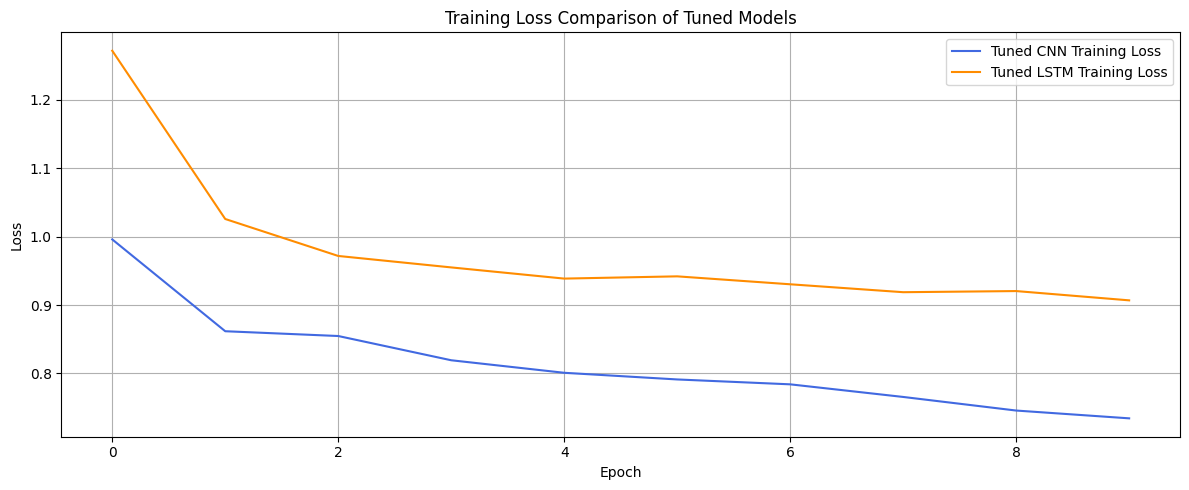

In [10]:
# --- 5. Main Execution ---

if __name__ == '__main__':
    # --- Load Data ---
    TENSOR_DIR = '/content/drive/MyDrive/AAI-511/preprocess'
    (X_train, y_train, train_lengths), \
    (X_test, y_test, test_lengths), \
    (X_val, y_val, val_lengths) = load_data(TENSOR_DIR)

    # --- Hyperparameter Grids ---
    cnn_param_grid = {
        'learning_rate': [0.001, 0.0001],
        'num_filters': [32, 64],
        'kernel_size': [3, 5],
        'dropout_prob': [0.2, 0.4]
    }
    lstm_param_grid = {
        'learning_rate': [0.001, 0.0001],
        'hidden_size': [64, 128],
        'num_layers': [1, 2],
        'dropout_prob': [0.2, 0.4]
    }

    # --- Run Tuning ---
    # Note: For a real scenario, you might run this once and save the best params.
    # Set a smaller number of epochs for faster tuning.
    NUM_TUNING_EPOCHS = 3

    best_cnn_params = hyperparameter_grid_search('CNN', cnn_param_grid, ((X_train, y_train, train_lengths), (X_val, y_val, val_lengths)), NUM_TUNING_EPOCHS)
    best_lstm_params = hyperparameter_grid_search('LSTM', lstm_param_grid, ((X_train, y_train, train_lengths), (X_val, y_val, val_lengths)), NUM_TUNING_EPOCHS)

    # --- Train Final Models with Best Hyperparameters ---
    NUM_EPOCHS = 10 # Full training epochs
    BATCH_SIZE = 64

    # Create DataLoaders
    train_loader = DataLoader(SequenceDataset(X_train, y_train, train_lengths), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(SequenceDataset(X_val, y_val, val_lengths), batch_size=BATCH_SIZE)
    test_loader = DataLoader(SequenceDataset(X_test, y_test, test_lengths), batch_size=BATCH_SIZE)

    # Common parameters
    input_size = X_train.shape[2]
    sequence_length = X_train.shape[1]
    num_classes = len(torch.unique(y_train))
    criterion = nn.CrossEntropyLoss()

    # Final CNN Model
    print("\n--- Training Final CNN Model with Best Hyperparameters ---")
    # Extract learning rate from best_cnn_params for optimizer
    cnn_learning_rate = best_cnn_params.pop('learning_rate')
    final_cnn_model = CNN(
        input_features=input_size,
        num_classes=num_classes,
        sequence_length=sequence_length,
        **best_cnn_params # Pass remaining model-specific params
    ).to(device)
    optimizer_cnn = optim.Adam(final_cnn_model.parameters(), lr=cnn_learning_rate)
    cnn_train_losses = train_model(final_cnn_model, train_loader, optimizer_cnn, criterion, device, NUM_EPOCHS)

    # Final LSTM Model
    print("\n--- Training Final LSTM Model with Best Hyperparameters ---")
    # Extract learning rate from best_lstm_params for optimizer
    lstm_learning_rate = best_lstm_params.pop('learning_rate')
    final_lstm_model = LSTM(
        input_size=input_size,
        num_classes=num_classes,
        **best_lstm_params # Pass remaining model-specific params
    ).to(device)
    optimizer_lstm = optim.Adam(final_lstm_model.parameters(), lr=lstm_learning_rate)
    lstm_train_losses = train_model(final_lstm_model, train_loader, optimizer_lstm, criterion, device, NUM_EPOCHS)

    # --- Evaluate Final Models ---
    print("\n--- Evaluating Final Models ---")
    val_loss_cnn, val_acc_cnn, val_prec_cnn, val_recall_cnn = evaluate_model(final_cnn_model, val_loader, criterion, device)
    test_loss_cnn, test_acc_cnn, test_prec_cnn, test_recall_cnn = evaluate_model(final_cnn_model, test_loader, criterion, device)

    val_loss_lstm, val_acc_lstm, val_prec_lstm, val_recall_lstm = evaluate_model(final_lstm_model, val_loader, criterion, device)
    test_loss_lstm, test_acc_lstm, test_prec_lstm, test_recall_lstm = evaluate_model(final_lstm_model, test_loader, criterion, device)

    # --- Compare and Visualize Results ---
    print("\n--- Final Model Performance Comparison ---")
    print(f"{'Metric':<22} | {'Tuned CNN':<15} | {'Tuned LSTM':<15}")
    print("-" * 57)
    print(f"{'Test Accuracy':<22} | {test_acc_cnn:<14.2%} | {test_acc_lstm:<14.2%}")
    print(f"{'Test Precision':<22} | {test_prec_cnn:<14.2%} | {test_prec_lstm:<14.2%}")
    print(f"{'Test Recall':<22} | {test_recall_cnn:<14.2%} | {test_recall_lstm:<14.2%}")
    print(f"{'Test Loss':<22} | {test_loss_cnn:<15.4f} | {test_loss_lstm:<15.4f}")
    print("-" * 57)
    print(f"{'Validation Accuracy':<22} | {val_acc_cnn:<14.2%} | {val_acc_lstm:<14.2%}")
    print(f"{'Validation Precision':<22} | {val_prec_cnn:<14.2%} | {val_prec_lstm:<14.2%}")
    print(f"{'Validation Recall':<22} | {val_recall_cnn:<14.2%} | {val_recall_lstm:<14.2%}")
    print(f"{'Validation Loss':<22} | {val_loss_cnn:<15.4f} | {val_loss_lstm:<15.4f}")
    print("-" * 57)

    # Plot training loss
    plt.figure(figsize=(12, 5))
    plt.plot(cnn_train_losses, label='Tuned CNN Training Loss', color='royalblue')
    plt.plot(lstm_train_losses, label='Tuned LSTM Training Loss', color='darkorange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison of Tuned Models')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [14]:
import torch

# Define the paths to save the models
cnn_model_save_path = '/content/drive/MyDrive/AAI-511/models/final_cnn_model.pth'
lstm_model_save_path = '/content/drive/MyDrive/AAI-511/models/final_lstm_model.pth'

# Save the state dictionary of the trained models
torch.save(final_cnn_model.state_dict(), cnn_model_save_path)
torch.save(final_lstm_model.state_dict(), lstm_model_save_path)

print(f"Tuned CNN model saved to: {cnn_model_save_path}")
print(f"Tuned LSTM model saved to: {lstm_model_save_path}")

Tuned CNN model saved to: /content/drive/MyDrive/AAI-511/models/final_cnn_model.pth
Tuned LSTM model saved to: /content/drive/MyDrive/AAI-511/models/final_lstm_model.pth
